In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import  mean_squared_error, r2_score

import statsmodels.api as sm

In [58]:
cal = pd.read_csv('calendar.csv.gz')
listd = pd.read_csv('listings.csv.gz')
lists = pd.read_csv('listings.csv')
revs = pd.read_csv('reviews.csv.gz')
nhood = pd.read_csv('neighbourhoods.csv')
purelst = pd.read_csv('listings.csv.gz')

In [59]:
# pd.set_option('display.max_colu?mns', 96)
pd.set_option('display.max_rows', 96)

In [60]:
#CLEANUP incoming dataframes

listd_drop_cols = ['scrape_id','last_scraped','experiences_offered','thumbnail_url','medium_url','xl_picture_url',\
                   'host_name','host_location','neighbourhood_group_cleansed','square_feet',\
                   'maximum_nights','is_business_travel_ready']

# listd_numc_cols
# listd_catz_cols

print(len(listd.columns), len(listd_drop_cols))
listd.drop(listd_drop_cols,axis=1,inplace=True )
print(len(listd.columns), len(listd_drop_cols))

96 12
84 12


# ALL TRANSFORMATIONS FUNCTIONS  : 

In [61]:
print(cal.date.min(),cal.date.max())
print(revs.date.min(),revs.date.max())
# print(lists.last_review.min(),lists.last_review.max())

2018-07-05 2019-07-04
2009-05-03 2018-07-05


In [62]:
# tmp=listd.copy() # Create a new copy of the existing dataframe otherwise it is only by reference
# tmp.head().T

In [63]:
def price_xform(dframe,colname):
    dframe[colname]=dframe[colname].str.replace('$','')
    dframe[colname]=dframe[colname].str.replace(',','')
    dframe[colname]=pd.to_numeric(dframe[colname])
#     return(dframe)

In [64]:
def cat_rename(dframe,colname,src,tgt):
    dframe[colname]=dframe[colname].str.replace(src,tgt)
#     dframe[colname]=dframe[colname].str.replace(',','')
#     dframe[colname]=pd.to_numeric(dframe[colname])
#     return(dframe)

In [65]:
def create_dummies(dframe,colname):
#     dfnew=dframe.copy()
    dframe=pd.get_dummies(data=dframe, columns=[colname])# create dummies and drop the parent column
    dframe.drop(columns=[dframe.columns[-1]],inplace=True) #dropped the last column from the add dummies
    return dframe

In [66]:
#Impute Null Rows based on the specified column
def impute_nullrows(dframe,colname):
    print(dframe[colname].isnull().sum())
    dftmp=dframe[~dframe[colname].isnull()]   # remove nulls from one column
    print(dftmp[colname].isnull().sum())
    return dftmp


# TRANSFORM ACTIONS

In [67]:
# Convert to Booleans
listd['host_is_superhost'] = listd.apply(lambda x:  x.host_is_superhost=='t', axis= 1)
listd['host_has_profile_pic'] = listd.apply(lambda x:  x.host_has_profile_pic=='t', axis= 1)
listd['host_identity_verified'] = listd.apply(lambda x:  x.host_identity_verified=='t', axis= 1)
listd['instant_bookable'] = listd.apply(lambda x:  x.instant_bookable=='t', axis= 1)

In [68]:
#Transform all the price columns to remove "$" and ","

price_xform(listd,'price')
price_xform(listd,'weekly_price')
price_xform(listd,'monthly_price')
price_xform(listd,'security_deposit')
price_xform(listd,'cleaning_fee')
price_xform(listd,'extra_people')

In [69]:
#Transform the room_type . to create a meaningful name and create dummies

cat_rename(listd,'room_type','Entire home/apt','full')
cat_rename(listd,'room_type','Private room','pvt')
cat_rename(listd,'room_type','Shared room','shared')

listd=create_dummies(listd,'room_type')
# listd=pd.get_dummies(data=listd, columns=['room_type'])  # create dummies and drop the parent column
# listd.drop(columns=[listd.columns[-1]],inplace=True)  #dropped the last column from the add dummies

In [70]:
#Transform the bed_type . to create a meaningful name and create dummies
listd['bed_type'] = listd.apply(lambda x: x.bed_type=='Real Bed', axis=1)

In [71]:
#Put a count on amenities,   IF it does not work, pick the most important feature
listd['amentcnt'] =   listd.apply(lambda x: len(x.amenities.split(",")), axis=1)

In [72]:
#!!! APPLY the same for the test data also
#Impute the to remove the rows with no zipcode.  !!! APPLY the same for the test data also
listd=listd[~listd['zipcode'].isnull()]   # remove nulls from one column




In [73]:
#Impute the null values with meaningful data

listd['cleaning_fee']=listd['cleaning_fee'].fillna(0)
listd['review_scores_cleanliness'] = listd['review_scores_cleanliness'].fillna(listd.review_scores_cleanliness.mean())

listd['review_scores_location'] = listd['review_scores_location'].fillna(listd.review_scores_location.mean())
listd['review_scores_value'] = listd['review_scores_value'].fillna(listd.review_scores_value.mean())




In [74]:
# mask1 = listd['minimum_nights']>7 
# mask2 = listd['minimum_nights']<=32
# maskmid=mask1 & mask2 
# maskmid = (listd['minimum_nights']>7) & (listd['minimum_nights']<=32)
# mask2
# maskmid
listd.loc[listd['minimum_nights']<=7,'min_night_stay'] = 'short'
listd.loc[(listd['minimum_nights']>7) & (listd['minimum_nights']<=32),'min_night_stay'] = 'mid'
listd.loc[listd['minimum_nights']>32,'min_night_stay'] = 'long'
listd=create_dummies(listd,'min_night_stay')

In [75]:
#Condensing the property_type to sub categories

listd.loc[listd['property_type']=='Apartment', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Condominium', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Guest suite', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Townhouse', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Guesthouse', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Tiny house', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Timeshare', 'ppt_condensed'] = 'apt'

listd.loc[listd['property_type']=='Serviced apartment', 'ppt_condensed'] = 'aptspl'
listd.loc[listd['property_type']=='Bed and breakfast', 'ppt_condensed'] = 'aptspl'
listd.loc[listd['property_type']=='Treehouse', 'ppt_condensed'] = 'aptspl'
listd.loc[listd['property_type']=='Cabin', 'ppt_condensed'] = 'aptspl'

listd.loc[listd['property_type']=='Bus', 'ppt_condensed'] = 'auto'
listd.loc[listd['property_type']=='Boat', 'ppt_condensed'] = 'auto'
listd.loc[listd['property_type']=='Camper/RV', 'ppt_condensed'] = 'auto'

listd.loc[listd['property_type']=='Hostel', 'ppt_condensed'] = 'hostel'

listd.loc[listd['property_type']=='Boutique hotel', 'ppt_condensed'] = 'hotel'
listd.loc[listd['property_type']=='Hotel', 'ppt_condensed'] = 'hotel'
listd.loc[listd['property_type']=='Resort', 'ppt_condensed'] = 'hotel'
listd.loc[listd['property_type']=='Aparthotel', 'ppt_condensed'] = 'hotel'

listd.loc[listd['property_type']=='House', 'ppt_condensed'] = 'house'
listd.loc[listd['property_type']=='Bungalow', 'ppt_condensed'] = 'house'
listd.loc[listd['property_type']=='Cottage', 'ppt_condensed'] = 'house'
listd.loc[listd['property_type']=='Villa', 'ppt_condensed'] = 'house'

listd.loc[listd['property_type']=='Other', 'ppt_condensed'] = 'other'

listd.loc[listd['property_type']=='Loft', 'ppt_condensed'] = 'room'

listd=create_dummies(listd,'ppt_condensed')

In [76]:
listd=create_dummies(listd,'zipcode')

In [77]:
#Removed the rows with price is equal to zero
listd=listd[listd.price>0]
listd.shape

(4662, 122)

In [78]:
#imputing some more missing values

listd['cleaning_fee'].fillna(0, inplace=True)
listd['beds'].fillna(0, inplace=True)
listd['bathrooms'].fillna(0, inplace=True)

In [79]:
# lreg_cols = ['price','weekly_price','cleaning_fee','accommodates','bedrooms','beds',\
#              'bathrooms','guests_included','zipcode']

listd_drop_cols2=['id', 'listing_url', 'name', 'summary', 'space', 'description',\
       'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',\
       'house_rules', 'picture_url', 'host_id', 'host_url', 'host_since',\
       'host_about', 'host_response_time', 'host_response_rate',\
       'host_acceptance_rate', 'host_thumbnail_url',\
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',\
       'host_total_listings_count', 'host_verifications',\
       'host_has_profile_pic', 'street',\
       'neighbourhood', 'neighbourhood_cleansed', 'city', 'state',\
       'market', 'smart_location', 'country_code', 'country', 'latitude',\
       'longitude', 'is_location_exact', 'property_type',\
       'amenities',\
       'weekly_price', 'monthly_price', 'security_deposit',\
       'extra_people', 'minimum_nights', 'calendar_updated',\
       'has_availability', 'availability_30', 'availability_60',\
       'availability_90', 'availability_365', 'calendar_last_scraped',\
       'number_of_reviews', 'first_review', 'last_review',\
       'review_scores_rating', 'review_scores_accuracy',\
       'review_scores_cleanliness', 'review_scores_checkin',\
       'review_scores_communication', 'review_scores_location',\
       'review_scores_value', 'requires_license', 'license',\
       'jurisdiction_names', 'instant_bookable', 'cancellation_policy',\
       'require_guest_profile_picture', 'require_guest_phone_verification',\
       'calculated_host_listings_count', 'reviews_per_month']
# listd_drop_cols2=['property_type','minimum_nights']
listd.drop(listd_drop_cols2,axis=1,inplace=True )

In [80]:
listd.columns

Index(['host_is_superhost', 'host_identity_verified', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'price', 'cleaning_fee',
       'guests_included', 'room_type_full', 'room_type_pvt', 'amentcnt',
       'min_night_stay_long', 'min_night_stay_mid', 'ppt_condensed_apt',
       'ppt_condensed_aptspl', 'ppt_condensed_auto', 'ppt_condensed_hostel',
       'ppt_condensed_hotel', 'ppt_condensed_house', 'ppt_condensed_other',
       'zipcode_94014.0', 'zipcode_94015.0', 'zipcode_94102.0',
       'zipcode_94103.0', 'zipcode_94104.0', 'zipcode_94105.0',
       'zipcode_94107.0', 'zipcode_94108.0', 'zipcode_94109.0',
       'zipcode_94110.0', 'zipcode_94111.0', 'zipcode_94112.0',
       'zipcode_94114.0', 'zipcode_94115.0', 'zipcode_94116.0',
       'zipcode_94117.0', 'zipcode_94118.0', 'zipcode_94121.0',
       'zipcode_94122.0', 'zipcode_94123.0', 'zipcode_94124.0',
       'zipcode_94127.0', 'zipcode_94129.0', 'zipcode_94131.0',
       'zipcode_94132.0', 'zipcode_94133.0

In [81]:
listd.shape

(4662, 50)

# EXTRA BEGIN

# EXTRA END

In [82]:
dfcorr=listd.corr()
# dfcorr.price.sort_values()


In [83]:
dfcorr.head()

,host_is_superhost,host_identity_verified,accommodates,bathrooms,bedrooms,beds,bed_type,price,cleaning_fee,guests_included,...,zipcode_94122.0,zipcode_94123.0,zipcode_94124.0,zipcode_94127.0,zipcode_94129.0,zipcode_94131.0,zipcode_94132.0,zipcode_94133.0,zipcode_94134.0,zipcode_94158.0
host_is_superhost,1.000000,0.176110,-0.066785,-0.073704,-0.068890,-0.093498,-0.021605,-0.013742,-0.036288,0.003894,...,0.047283,-0.008483,-0.001111,0.016106,-0.012819,0.017711,-0.016373,-0.024218,-0.011534,-0.018832
host_identity_verified,0.176110,1.000000,0.023722,0.038283,0.084281,0.009468,-0.021019,0.058457,0.064004,0.043997,...,-0.003876,-0.025903,0.009853,0.000215,0.010790,0.014966,-0.018309,-0.054209,-0.034937,-0.024633
accommodates,-0.066785,0.023722,1.000000,0.479894,0.769164,0.834911,0.071253,0.433958,0.549102,0.558845,...,0.009087,0.023262,-0.009771,0.008321,0.019512,0.012691,-0.023854,0.000806,0.027570,0.004030
bathrooms,-0.073704,0.038283,0.479894,1.000000,0.554435,0.493763,0.036435,0.334272,0.376441,0.284819,...,-0.020596,0.037558,-0.014459,0.025774,-0.006685,0.002333,0.021209,-0.040651,-0.012187,0.003814
bedrooms,-0.068890,0.084281,0.769164,0.554435,1.000000,0.730484,0.046284,0.434292,0.581118,0.520190,...,-0.004132,0.037703,-0.023691,0.021538,0.009484,0.034552,-0.015237,0.012223,0.007016,0.001407


In [84]:
dfcorr.price.sort_values()

room_type_pvt            -0.256935
zipcode_94112.0          -0.077826
ppt_condensed_hostel     -0.065285
zipcode_94124.0          -0.058418
zipcode_94122.0          -0.047006
zipcode_94132.0          -0.044017
zipcode_94102.0          -0.043951
zipcode_94134.0          -0.037983
min_night_stay_mid       -0.035109
zipcode_94111.0          -0.027142
ppt_condensed_hotel      -0.026607
ppt_condensed_apt        -0.025683
zipcode_94110.0          -0.025396
zipcode_94014.0          -0.022799
ppt_condensed_aptspl     -0.020199
zipcode_94127.0          -0.018459
zipcode_94116.0          -0.015249
ppt_condensed_auto       -0.014055
host_is_superhost        -0.013742
ppt_condensed_other      -0.013267
zipcode_94015.0          -0.009269
zipcode_94107.0           0.001506
zipcode_94108.0           0.001901
zipcode_94118.0           0.002310
zipcode_94105.0           0.002917
zipcode_94131.0           0.003698
zipcode_94129.0           0.004251
zipcode_94158.0           0.005958
zipcode_94103.0     

'''
lreg_cols_master = ['square_feet','weekly_price','cleaning_fee','accommodates','bedrooms','beds','bathrooms','guests_included','zipcode']
lreg_cols = ['price','weekly_price','cleaning_fee','accommodates','bedrooms','beds','bathrooms','guests_included','zipcode']
'''

In [85]:
dflreg = listd.copy()
dflreg = sm.add_constant(dflreg)

In [86]:
dflreg['host_is_superhost'] = (dflreg['host_is_superhost'] == True).astype(int)
dflreg['host_identity_verified'] = (dflreg['host_identity_verified'] == True).astype(int)
dflreg['bed_type'] = (dflreg['bed_type'] == True).astype(int)

In [87]:
dfscatter=dflreg.loc[:,'price':'guests_included']
dfscatter.head()

,price,cleaning_fee,guests_included
0,170.0,100.0,2
1,235.0,100.0,2
2,65.0,50.0,1
3,63.0,30.0,1
4,65.0,50.0,1


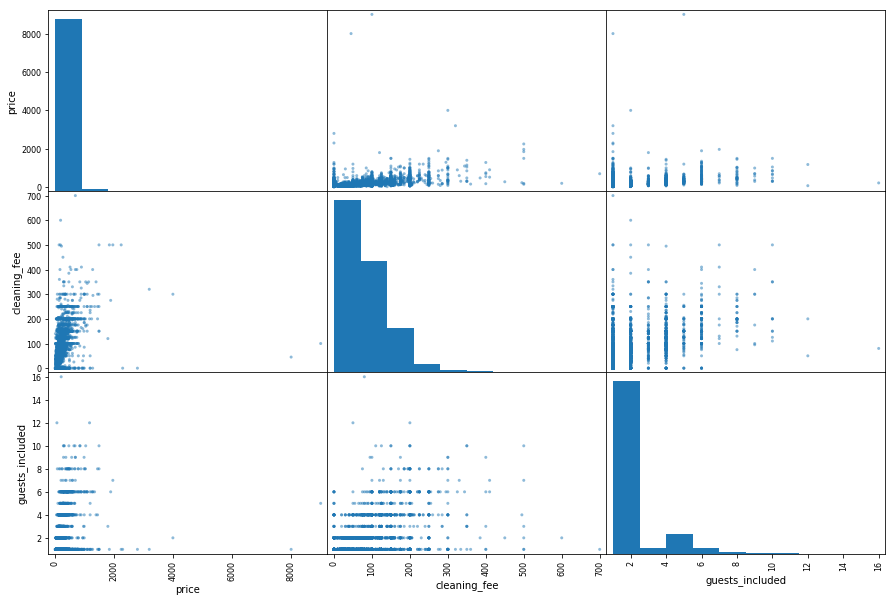

In [88]:
pd.plotting.scatter_matrix(dfscatter,figsize=(15,10));

In [89]:
y=dflreg.price
X=dflreg.drop(['price'],axis=1)

In [90]:
X_chunk, X_test, y_chunk, y_test = train_test_split(X, y, test_size=0.20, random_state=47)
X_train, X_vald, y_train, y_vald = train_test_split(X_chunk, y_chunk, test_size=0.20, random_state=47)

In [91]:
X_train = X_chunk.copy()
y_train = y_chunk.copy()

In [92]:
print(X_train.shape, X_vald.shape, X_test.shape)
print(y_train.shape, y_vald.shape, y_test.shape)

(3729, 50) (746, 50) (933, 50)
(3729,) (746,) (933,)


In [93]:
lmodel = linear_model.LinearRegression()
lmodel.fit(X_train,y_train)
y_predsk = lmodel.predict(X_test)

In [94]:
print('Coefficients: \n', lmodel.coef_)

Coefficients: 
 [-1.89941430e-13  1.41184521e+01  1.80920910e+01  2.01090408e+01
  5.10654309e+01  4.92445288e+01 -9.94020873e+00 -7.08888519e+00
  5.68332612e-01  3.07191347e+00  6.96077836e+01  3.35076911e+01
 -1.55309033e-01  1.20251141e+02 -4.64731820e+01 -4.30685410e+01
 -5.77370611e+01 -5.51636346e+01 -8.70795420e+01 -4.87780277e+00
 -2.55707278e+01 -4.54948305e+01 -5.43849738e+01  9.84599223e-01
  4.99665973e+01  4.45147022e+01  3.52434388e+02  6.18436737e+01
  9.17021941e-01  9.68915230e+01  7.39656438e+01 -2.46448001e+01
  7.07438235e+01 -6.18323776e+01  2.44117724e+01  5.43618946e+01
  7.83515098e+00  4.81768227e+00 -1.21774756e+01 -3.17904921e+01
 -4.88235055e+01  8.16474410e+01 -7.36046259e+01 -4.17244061e+01
  3.16833538e+00 -1.28502468e+01 -6.22321133e+01  1.39605570e+02
 -6.49503696e+01  6.17251986e+01]


In [95]:
y_predsk.shape

(933,)

In [96]:
from sklearn.utils import check_array
import numpy as np
def mse_prop(y_true, y_pred): 


    return (np.mean(np.abs((y_true - y_pred)**2 / (y_true+1)**2  )) * 100) **0.5



In [97]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_predsk))
print("Variance squared error: %.2f" % r2_score(y_test, y_predsk))
print("MSE Proportion: %.2f" % mse_prop(y_test, y_predsk))

Mean squared error: 29373.96
Variance squared error: 0.38
MSE Proportion: 6.49


In [98]:
#Building Residual DF

dfpred= y_test.to_frame()
dfpred['sk_preds'] = y_predsk
dfpred['sk_resid'] = dfpred.sk_preds-dfpred.price
dfpred['sk_residpct'] = (dfpred.sk_preds-dfpred.price)/dfpred.price
# dfpred.head()

Text(0,0.5,'RESIDUAL PCT')

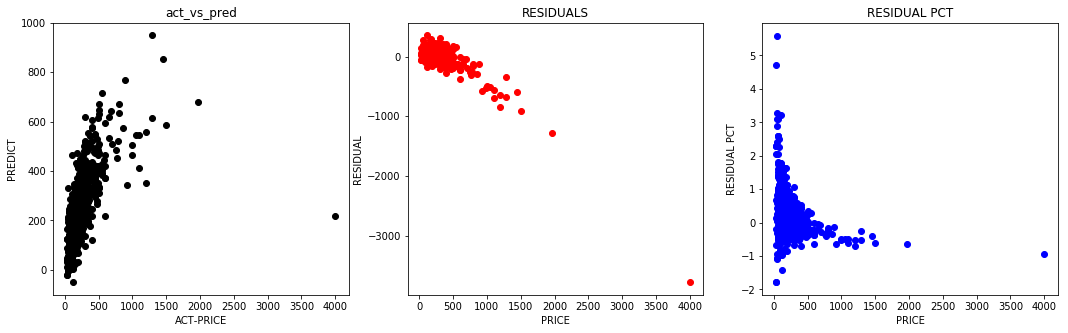

In [99]:
fig = plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_test, y_predsk,  color='black')
ax1.set_title('act_vs_pred')
ax1.set_xlabel('ACT-PRICE')
ax1.set_ylabel('PREDICT')

ax2.scatter(dfpred.price,dfpred.sk_resid, color='red')
ax2.set_title('RESIDUALS')
ax2.set_xlabel('PRICE')
ax2.set_ylabel('RESIDUAL')

ax3.scatter(dfpred.price,dfpred.sk_residpct, color='blue')
ax3.set_title('RESIDUAL PCT')
ax3.set_xlabel('PRICE')
ax3.set_ylabel('RESIDUAL PCT')

In [100]:
y_predsk

array([ 69.51625907, 175.46952149, 520.46988994, 631.15885178,
       114.59473344, 352.1947233 , 247.79583993, 213.15334624,
       234.48569486, 158.18684482, 558.63735537, 228.19420279,
       545.72655725,  76.79854413,  37.39440325, 342.7481994 ,
       295.9177308 , 211.11883021,  74.69503897,  95.56845323,
       267.6334068 , 423.7594246 , 109.64349459,  75.4036055 ,
       116.48883686, 388.25005434,  -3.95825597, 119.62397545,
       239.37721523,  60.34486038,  50.81177453, 680.73090523,
       170.49837614, 129.59715097, 108.23131457, 288.56950001,
       216.69532152, 208.49956916, 206.31521462, 223.04655936,
       129.59715097, 403.16593696, 111.34795508, 189.78795979,
       239.37578724, 388.1880137 , 196.91388567,  17.16360263,
        98.24086071, 209.2755799 , 451.15482651,  51.07431536,
       133.33285433, 200.09592581, 320.83811451,  83.60233392,
       284.98747082, 301.935228  , 206.23328253, 128.04406064,
       294.82691049, 243.90988468, 120.79449349, 357.75

In [101]:
y_test.head()

4327    200.0
2326    140.0
3190    780.0
1900    499.0
1622     93.0
Name: price, dtype: float64

In [102]:
print( y_train.shape, X_train.shape)

(3729,) (3729, 50)


In [103]:
listd_insig_cols = ['host_identity_verified','bed_type','guests_included','room_type_pvt','amentcnt',]

In [104]:
import statsmodels.api as sm
import numpy as np
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     27.34
Date:                Tue, 07 Aug 2018   Prob (F-statistic):          1.32e-208
Time:                        04:26:02   Log-Likelihood:                -25663.
No. Observations:                3729   AIC:                         5.143e+04
Df Residuals:                    3679   BIC:                         5.174e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -39

354.88073232206807


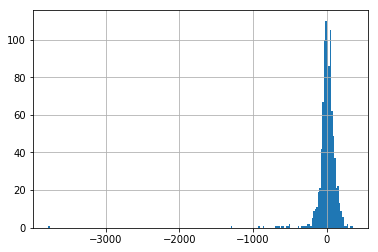

In [105]:
y_resdsk=(y_predsk-y_test)
print(y_resdsk.max())
y_resdsk.hist(bins =200)

548.1480034878823


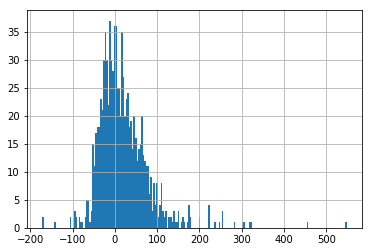

In [106]:
y_resdpct=(y_predsk-y_test)*100/(y_test+1)
print(y_resdpct.max())
y_resdpct.hist(bins =200)

In [107]:
dflreg.describe()

,const,host_is_superhost,host_identity_verified,accommodates,bathrooms,bedrooms,beds,bed_type,price,cleaning_fee,...,zipcode_94122.0,zipcode_94123.0,zipcode_94124.0,zipcode_94127.0,zipcode_94129.0,zipcode_94131.0,zipcode_94132.0,zipcode_94133.0,zipcode_94134.0,zipcode_94158.0
count,4662.0,4662.000000,4662.000000,4662.000000,4662.000000,4662.000000,4662.000000,4662.000000,4662.000000,4662.000000,...,4662.000000,4662.000000,4662.000000,4662.000000,4662.000000,4662.000000,4662.000000,4662.000000,4662.000000,4662.000000
mean,1.0,0.433719,0.648220,3.341699,1.286251,1.390605,1.827971,0.985628,218.081296,78.284642,...,0.048263,0.028314,0.021450,0.020163,0.000215,0.047619,0.010296,0.033677,0.016517,0.002574
std,0.0,0.495641,0.477577,1.995741,0.627235,0.941283,1.227591,0.119029,265.054814,67.450150,...,0.214343,0.165886,0.144895,0.140573,0.014646,0.212982,0.100956,0.180415,0.127465,0.050675
min,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,100.000000,30.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,155.000000,67.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.0,1.000000,1.000000,4.000000,1.500000,2.000000,2.000000,1.000000,250.000000,100.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.0,1.000000,1.000000,16.000000,7.000000,7.000000,14.000000,1.000000,9000.000000,700.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


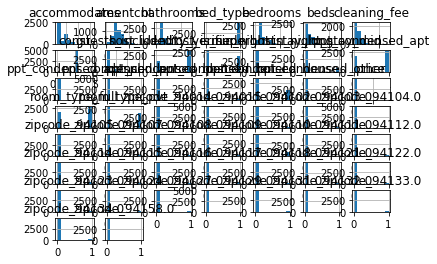

In [108]:
plt_cols = dflreg.columns
ax = dflreg[plt_cols].hist(bins=10)
plt.plot();

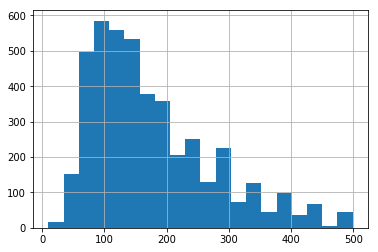

In [109]:
dflreg['price'][dflreg['price']<500].hist(bins=20);

In [110]:
# dflreg['price'][[dflreg['price']>500 & dflreg['price']<2000]].hist(bins=20);

In [111]:
pd.crosstab(dflreg['bedrooms'], dflreg['beds'])

beds,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,10.0,12.0,14.0
bedrooms,,,,,,,,,,,,
0,5,317,128,8,3,0,0,0,0,0,0,0
1,30,2073,525,68,24,6,0,0,1,0,0,1
2,13,11,560,193,66,8,4,2,0,0,0,0
3,8,5,17,236,135,38,17,3,0,0,0,0
4,7,1,0,0,51,44,14,8,5,0,0,0
5,1,0,0,0,0,9,2,2,5,1,0,0
6,0,0,0,0,0,0,2,1,1,0,1,0
7,0,0,0,0,0,0,0,1,0,0,0,1


In [112]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import accuracy_score, mean_squared_error
from collections import Counter